In [73]:
!git clone https://github.com/davda54/sam

fatal: destination path 'sam' already exists and is not an empty directory.


In [74]:
import sys; sys.path.append("..")

sys.path.append("sam")
from sam import SAM

In [75]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm.notebook import tqdm, trange
from sklearn import datasets
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"

In [76]:
def _reshape(my_item, target):
  #print(f"My item: {my_item}")
  target_shapes = [i.size() for i in target]
  #print(f"Target shapes: {target_shapes}")
  target_sizes = [torch.numel(i) for i in target]
  #print(f"Target sizes: {target_sizes}")
  assert torch.numel(my_item) == sum(target_sizes)
  chunked_item = torch.tensor_split(my_item, tuple(np.cumsum(target_sizes))[:-1])
  #print(f"Chunked item: {chunked_item}")
  reshaped_item = [item.reshape(target_shapes[i]) for i, item in enumerate(chunked_item)]
  #print(f"Reshaped item: {reshaped_item}")
  return reshaped_item

a = torch.tensor([1, 2, 3, 4, 5, 6, 7])
b = [torch.tensor([[1, 2], [3, 4]]), torch.tensor([5, 6, 7])]
_reshape(a, b)


[tensor([[1, 2],
         [3, 4]]),
 tensor([5, 6, 7])]

In [77]:
class MegaSAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, M, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(MegaSAM, self).__init__(params, defaults)

        self.M = M
        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm, grads_list, grads_flattened = self._grad_norm()
        scale = self.param_groups[0]['rho'] / (grad_norm + 1e-12)  # replace with rho
        M_inv = 1 / self.M
        e_w = M_inv * grads_flattened * scale
        reshaped_e_w = _reshape(e_w, grads_list)
        #print(reshaped_e_w)
        for group in self.param_groups:
          for index, p in enumerate(group["params"]):
            if p.grad is None: continue
            self.state[p]["old_p"] = p.data.clone()
            p.add_(reshaped_e_w[index])

        if zero_grad: self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None: continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad: self.zero_grad()
    
    @torch.no_grad()
    def m_step(self, zero_grad=False):
      alpha = 0.05  # betenni paraméternek
      grad_norm, grads_list, grads_flattened = self._grad_norm()
      M_inv = 1 / self.M
      grad_matrix_prod = grads_flattened * M_inv
      update = 0.5 * (((self.param_groups[0]["rho"]) / grad_norm) * grad_matrix_prod * grad_matrix_prod
                      + alpha * M_inv**2 / torch.sqrt(torch.sum(M_inv)))
      self.M = self.M + 0.01 * update  # eta2-t átírni


    @torch.no_grad()
    def step(self, closure=None):
        assert closure is not None, "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(closure)  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()
        self.m_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][0].device  # put everything on the same device, in case of model parallelism
        M_inv = 1 / self.M
        grads_list = [ 
                  p.grad.to(shared_device)   # removed p=2 norm here
                  for group in self.param_groups for p in group["params"]
                  if p.grad is not None
                    ]
        grads_flattened = torch.cat([
                        item.flatten().to(shared_device)   # removed p=2 norm here
                        for item in grads_list
                    ])
        norm = torch.sqrt(M_inv.T @ grads_flattened**2)
               
        return norm, grads_list, grads_flattened

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups


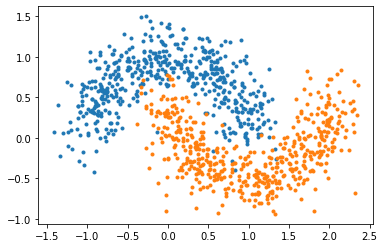

In [78]:
N = 1000

def data_gen():
    all_data = []
    X,y = datasets.make_moons(n_samples=N, shuffle=True, noise=0.2, random_state=1234)
    y = np.reshape(y, (len(y),1))
    for index, point in enumerate(X):
        point=np.reshape(point, (2,1))
        all_data.append([torch.tensor(point), y[index][0]])
    return all_data
  
all_data = data_gen()

zeros_x = [all_data[i][0][0] for i in range(N) if not all_data[i][1]]
zeros_y = [all_data[i][0][1] for i in range(N) if not all_data[i][1]]

ones_x = [all_data[i][0][0] for i in range(N) if all_data[i][1]]
ones_y = [all_data[i][0][1] for i in range(N) if all_data[i][1]]

plt.plot(zeros_x, zeros_y, '.')
plt.plot(ones_x, ones_y, '.')

train_data = all_data[:N*8//10]
test_data = all_data[N*8//10:]
batch_size = 1000
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [79]:
from tqdm.notebook import tqdm, trange

output1 = 10

model = nn.Sequential(
    nn.Linear(2, output1),
    nn.ReLU(),
    nn.Linear(output1, 1)
)

def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

num_params = get_n_params(model)
M = torch.ones(num_params)

epochs = 1000

base_optimizer = torch.optim.SGD
optimizer = MegaSAM(model.parameters(), base_optimizer, M, lr = 0.01)
criterion = nn.BCEWithLogitsLoss()

for epoch in trange(epochs):
    for points, labels in train_loader:
        
        optimizer.zero_grad()

        x = points[:,:,0].float()
        x = x.to(device)
        labels = labels[:,None].double()

        def closure():
          loss = criterion(model(x), labels)
          loss.backward()
          return loss

        y = model(x)
        loss = criterion(y, labels)
        
        loss.backward()
        optimizer.step(closure)
    


  0%|          | 0/1000 [00:00<?, ?it/s]

In [80]:
correct_test = 0
with torch.no_grad():
        # Iterate through test set minibatchs 
        for numbers2, labels2 in test_loader:
            numbers2 = numbers2
            labels2 = labels2.double()[:,None]
            # Forward pass
            x2 = numbers2[:,:,0].float()
            y2 = model(x2)
            predictions2 = ((y2>0)*1)
            correct_test += torch.sum((predictions2 == labels2).float())
print(f'Test accuracy: {correct_test/len(test_data)}')

Test accuracy: 0.8450000286102295


In [92]:
def _flatten_and_together(list_of_tensors):
    new_list = []
    for tensor in list_of_tensors:
        new_list.append(torch.flatten(tensor))
    return torch.cat(new_list)

correct_test = 0
fischer_test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)

fischer = torch.zeros((N, N))

# Iterate through test set minibatchs 
for numbers2, labels2 in fischer_test_loader:
    labels2 = labels2.double()[:,None]
    # Forward pass
    x2 = numbers2[:,:,0].float()
    y2 = model(x2)
    labels = torch.sigmoid(y2.detach())
    loss_fn = nn.BCEWithLogitsLoss()
    loss = loss_fn(y2, labels)
    #model.zero_grad()
    loss.backward()
    g = _flatten_and_together([p.grad for p in model.parameters()])
    print(f"shape of g: {g.size()}")
    print(f"g: {g}")
    fischer += g.T @ g
fischer = fischer / N
print(fischer)



shape of g: torch.Size([41])
g: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
shape of g: torch.Size([41])
g: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
shape of g: torch.Size([41])
g: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
shape of g: torch.Size([41])
g: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
shape of g: torch.Size([41])
g: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [ ]:
optimizer.M

tensor([1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012,
        1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012,
        1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012, 1.0012,
        1.0012, 1.0012, 1.0012, 1.0022, 1.0012, 1.0014, 1.0012, 1.0012, 1.0012,
        1.0012, 1.0013, 1.0012, 1.0012, 1.0013])